In [1]:
import pandas as pd
teams = pd.read_csv("teams5sb.csv", index_col=[0,1])

teams.columns=[x.lower() for x in teams.columns]

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt
import numpy as np


In [2]:
us = pd.read_csv("usPPDA.csv", index_col=[0,1])
us=us[['PPDA']].rename(columns={'PPDA':'ppda'})
teams=teams.join(us)

In [50]:
# Create train/test split for initial holdout
from sklearn.model_selection import train_test_split

def reg_prep(dfnr,to_pred_cols_lst,test_size=0.3):
    # Create arrays for features and target variable
    df_to_pred= dfnr[to_pred_cols_lst]
    y = df_to_pred.values
    df_wo_y = dfnr.drop(to_pred_cols_lst,axis='columns')
    X = df_wo_y.values

    y_labels=df_to_pred.columns
    x_labels=df_wo_y.columns
    return X, y, x_labels,y_labels


def reg_prep_split(X, y,test_size=0.3):
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
    return X_train, X_test, y_train, y_test

def categorical_prep(df1,col):
# if CATEGORICAL data
# Create dummy variables: 
    df2=df1.join(pd.get_dummies(df1[col]))
    df2.drop([col],axis='columns', inplace=True)
    return df2

def categorical_code(pds):
    return pds.astype("category").cat.codes

def importants(labels,coefs):
    df1=pd.DataFrame()
    df1['a']=labels
    df1['b']=coefs
    df1=df1.sort_values('b',key=lambda x:-abs(x))[df1.b.abs()>0.0]
    return(df1)


In [103]:
# bramkarz-obrona-pomoc-atak-trener
# (PSxG-GA)/SoT; opp_xG; xG; Gls/xG
# ; SoTA; SCA; ;
bramkarz=['psxg','ga','sot']
obrona=['opp_xg','sota']
pomoc=['xg','sca']
atak=['gls','xg']
trener=['opp_xg'] #'opp_xg' vs AVGopp_xg

taktyka =['dist','cpa','1/3']# Dist(shot) C1/3 CPA
offence=['def pen','def 3rd','mid 3rd','att 3rd','att pen','touches'] #Touches[Def3rd Mid3rd Att3rd]/Touches
intensity=['touches']
wide=['sw','crs','att','opp_ti'] #/Poss Sw Crs Take-Ons[Att]'opp_ti'
speed=['poss','prgdist'] #PrgP/Poss poss/prgdist
stalefragmenty =['dead','fk','ti','ck', 'gca passdead'] #/Poss Dead,FK,TI,CK GCA pass dead
press=['sca def','tackles def 3rd', 'tackles mid 3rd', 'tackles att 3rd','tackles tkl','fls','won','opp_rec','opp_total cmp','opp_total att','recov']
# SCA_Def,Tackles[Def3rd Mid3rd Att3rd], *oppRec, Fls AWon 
where=['tackles def 3rd','tackles mid 3rd','tackles att 3rd','def 3rd','mid 3rd','att 3rd','att pen','def pen']
error=['challenges lost','tackles tklw','tackles tkl','err','mis','dis','crdy','og','lost']
# ChallengesLost TklW/TklAtt Err Mis Dis CrdY OG Alost
succ=['int','tackles tklw','succ','challenges tkl','blocks','opp_total att','recov'] #Int TklW ChaTkl Take-Ons[Att] blocks 'opp_total att'

subset=bramkarz+obrona+pomoc+atak+trener+taktyka+offence+intensity+wide+speed+stalefragmenty+press+error+where
subset=list(set(subset))
len(subset)
df=teams[subset+['ppda']]
def norm(df):
    return (df-df.min())/(df.max()-df.min())
# norm(sel['xG']).sort_values()
# sel.rank(pct = True)
dfn=norm(df)
dfn=df
dfnr=dfn.reset_index(drop=True)


In [104]:
possible=['tackles att 3rd','tackles mid 3rd','fls','opp_total att','opp_total cmp','opp_rec',
'def 3rd','att 3rd','mid 3rd', 'touches',
'sca def', 'recov'
]
possible2=['opp_total att','opp_total cmp','opp_rec','def 3rd','att 3rd','mid 3rd', 'touches']#85
possible3=['opp_total cmp','def 3rd','att 3rd','mid 3rd', 'touches']#81
possible4=['tackles att 3rd','tackles mid 3rd','opp_total att','opp_total cmp','opp_rec']#91
possible5=['tackles att 3rd','tackles mid 3rd','poss']#84
dfnr=dfnr[possible4+['ppda']]

In [105]:

X,y,cols,_ =reg_prep(dfnr,['ppda'])
X_train, X_test, y_train, y_test,= reg_prep_split(X,y)

[[-0.02012108 -0.01357661 -0.00112105 -0.00247494  0.00450804]]


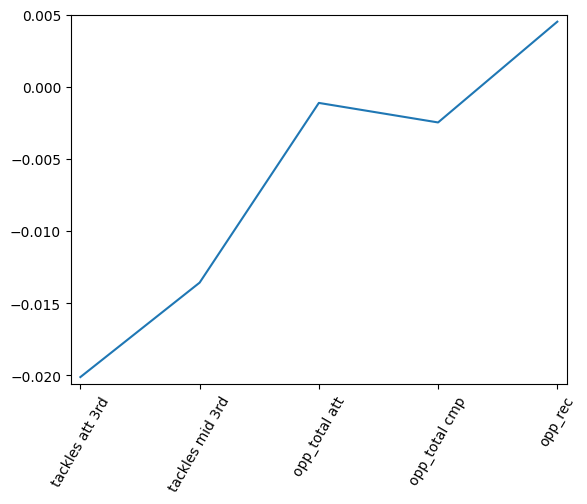

[0.88587079 0.88146052 0.79282876 0.91564152 0.9015946 ]
0.8754792362146935
R^2 on holdout
0.9109966890373531
RMSE:0.6791137880524861


In [106]:
# LinearRegression

# Import necessary modules
from sklearn.linear_model import LinearRegression

# Create the regressor: reg_all
reg = LinearRegression()

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg.predict(X_test)

# Compute and print the coefficients
print(reg.coef_)

# Plot the coefficients
plt.plot(range(len(cols)), reg.coef_[0])
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X_train, y_train, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)
print(np.mean(cv_scores))


# Compute and print R^2 on holdout
print('R^2 on holdout')
print(reg.score(X_test, y_test))

# Compute mse_lr
mse_lr = MSE(y_test, y_pred)
# Compute rmse_lr
rmse_lr = mse_lr**(1/2)
print(f'RMSE:{rmse_lr}')

In [107]:
importants(cols,reg.coef_[0])
# 'def 3rd'	2.124962
# 'att 3rd'	3.314165
# 'mid 3rd'	5.696687
# 'opp_total' cmp	8.055689

# 'touches'	-8.794730
# 'opp_rec'	-5.982921
# 'opp_total att'	-1.608765

# rmse058->073
# att 3rd	1.603505
# mid 3rd	3.117047
# def 3rd	0.972024
# touches	-4.678860

# opp_rec	1.598245
# opp_total cmp	0.851130
# opp_total att	-1.722075

# rmse 0.86
# att 3rd	0.003138
# mid 3rd	0.003673
# def 3rd	0.003189
# touches	-0.003464

# opp_total cmp	0.001051
# opp_rec	0.001990
# opp_total att	-0.001982

# last91
# 'tackles att 3rd'	-0.020121
# 'tackles mid 3rd'	-0.013577
# 'opp_rec'	0.004508
# 'opp_total cmp'	-0.002475
# 'opp_total att'	-0.001121



C:\Users\krawc\AppData\Local\Temp\ipykernel_13080\3723120590.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1=df1.sort_values('b',key=lambda x:-abs(x))[df1.b.abs()>0.0]


,a,b
0,tackles att 3rd,-0.020121
1,tackles mid 3rd,-0.013577
4,opp_rec,0.004508
3,opp_total cmp,-0.002475
2,opp_total att,-0.001121


In [109]:
xx=teams[possible4].values
pred_col = reg.predict(xx)


In [114]:
teams['yppda']=y
teams['qppda']=pred_col
teams['qppdac']=8.1402+teams['tackles att 3rd']*-0.020121+teams['tackles mid 3rd']*-0.013577+teams['opp_rec']*0.004508+teams['opp_total cmp']*-0.002475+teams['opp_total att']*-0.001121

teams[['ppda','qppda','yppda','qppdac']]

ppda      qppda  yppda     qppdac
1819 Arsenal           9.47   9.629733   9.47   9.629891
     Bournemouth      15.34  13.791801  15.34  13.791813
     Brighton         13.63  14.138685  13.63  14.138595
     Burnley          13.58  12.950498  13.58  12.950480
     Cardiff City     14.64  13.971108  14.64  13.971040
...                     ...        ...    ...        ...
2223 Nott'ham Forest  16.48  15.260967  16.48  15.260850
     Southampton      12.37  12.773026  12.37  12.772983
     Tottenham        12.65  13.559588  12.65  13.559556
     West Ham         15.96  15.440374  15.96  15.440216
     Wolves           11.99  12.113765  11.99  12.113804

[100 rows x 4 columns]

<Axes: >

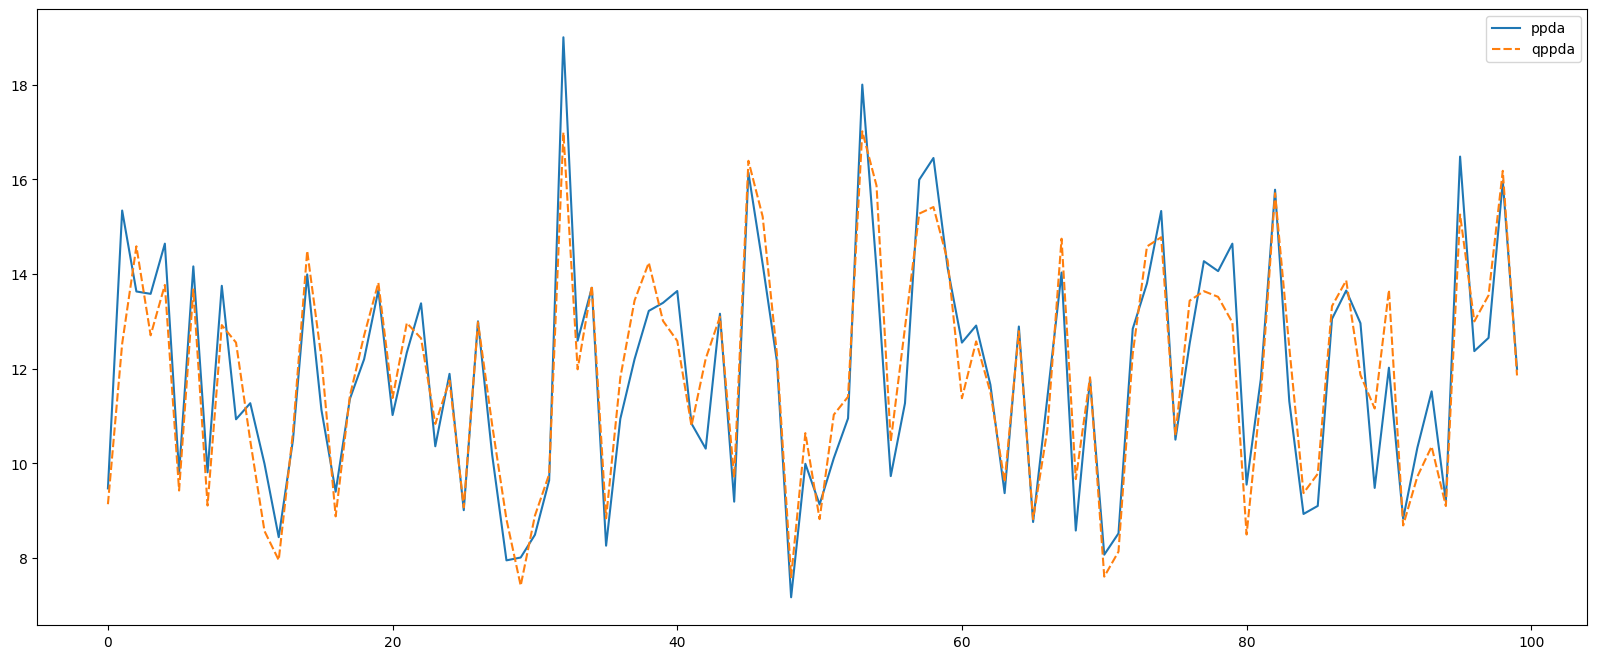

In [56]:
import seaborn as sns
# import matplotlib.pyplot as plt
data = teams[['ppda','qppda']].reset_index(drop=1)
fig = plt.subplots(figsize=(20, 8))
sns.lineplot(data=data,estimator=None)

[-0.        -0.        -0.         0.         0.         0.4476806
 -0.        -0.        -0.        -0.        -0.        -0.       ]


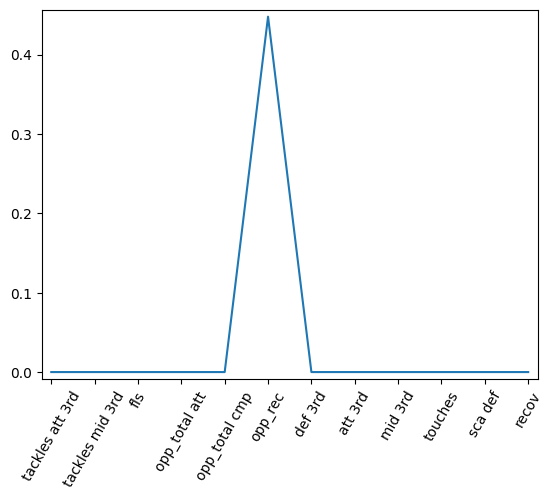

[0.54233865 0.67376668 0.62162657 0.48749266 0.8200232 ]
0.6290495509736198
R^2 on holdout
0.6963657505957312


In [96]:
#LASSO

# Import Lasso
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# # Instantiate a lasso regressor: lasso
# lasso = Lasso(alpha=0.3, normalize=True)

# # Fit the regressor to the data
# lasso.fit(X_train,y_train)


# Setup the pipeline steps: steps
steps = [
        # ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=0.02))
        ]
pipeline = Pipeline(steps)
lasso = pipeline.fit(X_train, y_train)
lasso_coef = pipeline.named_steps['lasso'].coef_
# Compute and print the coefficients
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(cols)), lasso_coef)
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: 
lasso_cv = cross_val_score(lasso, X_train, y_train, cv=5)

# Print the cross-validated scores
print(lasso_cv)
print(np.mean(lasso_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(lasso.score(X_test, y_test))

[[-0.11218451 -0.15379407 -0.14990182  0.16464911  0.23347195  0.23474082
   0.06236178 -0.03597908 -0.00182068 -0.00194346  0.0021732  -0.06712331]]


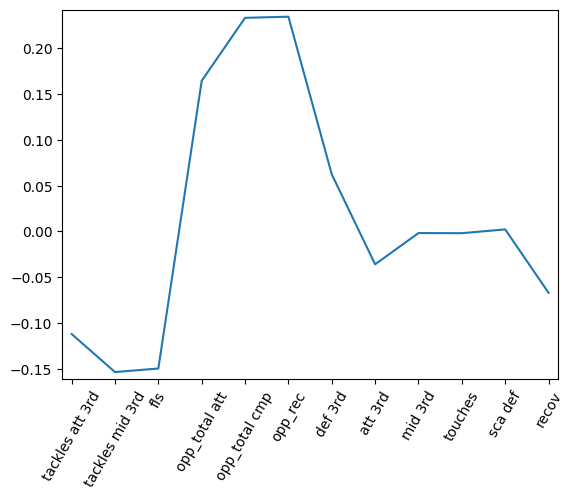

[0.88183068 0.76429852 0.86123712 0.90360963 0.91942269]
0.8660797274471216
R^2 on holdout
0.884203390789048
Test set RMSE: 0.065


In [97]:
# RIDGE

# Import necessary modules
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Setup the pipeline steps: steps
steps = [
    # ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=0.8))]
pipeline = Pipeline(steps)
ridge = pipeline.fit(X_train, y_train)
ridge_coef = pipeline.named_steps['ridge'].coef_

# Compute and print the coefficients
print(ridge_coef)

# Plot the coefficients
plt.plot(range(len(cols)), ridge_coef[0])
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: ridge_cv
ridge_cv = cross_val_score(ridge, X_train, y_train, cv=5)

# Print the cross-validated scores
print(ridge_cv)
print(np.mean(ridge_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(ridge.score(X_test, y_test))

y_pred=ridge.predict(X_test)
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
# Print rmse_test
print('Test set RMSE: {:.3f}'.format(rmse_test))

[-0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0.]


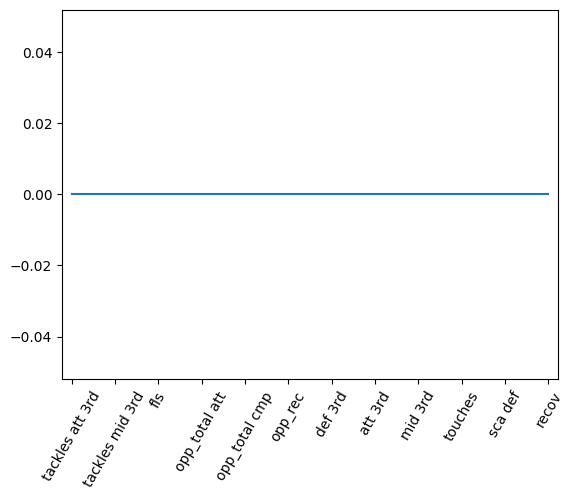

[-0.50801729 -0.10255185 -0.00702659 -0.03076621 -0.01861594]
-0.13339557693439047
R^2 on holdout
-0.00026760608437625955


In [99]:
#elastic net

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Setup the pipeline steps: steps
steps = [
    # ('scaler', StandardScaler()),
        ('elastic_net', ElasticNet(l1_ratio=0.6, alpha=0.1))]
pipeline = Pipeline(steps)
elastic_net = pipeline.fit(X_train, y_train)
elastic_net_coef = pipeline.named_steps['elastic_net'].coef_

# Compute and print the coefficients
print(elastic_net_coef)

# Plot the coefficients
plt.plot(range(len(cols)), elastic_net_coef)
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: ridge_cv
elastic_net_cv = cross_val_score(elastic_net, X_train, y_train, cv=5)

# Print the cross-validated scores
print(elastic_net_cv)
print(np.mean(elastic_net_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(elastic_net.score(X_test, y_test))



In [74]:

importants(cols,elastic_net_coef)
# 'tackles att 3rd'	-0.080634
# 'tackles mid 3rd	'-0.066822
# 'fls'	-0.052099
# 'opp_total cmp'	0.300728
# 'opp_rec'	0.308767
# 'tackles att 3rd','tackles mid 3rd','fls','opp_total cmp','opp_rec'

C:\Users\krawc\AppData\Local\Temp\ipykernel_2696\3271778965.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1=df1.sort_values('b',key=lambda x:-abs(x))[df1.b.abs()>0]


,a,b
3,opp_rec,0.308767
4,opp_total cmp,0.300728
7,tackles att 3rd,-0.080634
2,tackles mid 3rd,-0.066822
34,fls,-0.052099
42,challenges lost,-0.039009
14,ti,-0.014101
26,opp_total att,0.003036


In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE

In [111]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.3, random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_pred, y_test)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

Test set RMSE of dt: 0.16


In [112]:
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))
# if CV RMSE is > Tree test set RMSE - means overfitting -> model too compilcated -> reduce parameters

CV RMSE: 0.13


In [113]:
# compare linear error vs tree error

# Predict test set labels 
y_pred_lr = reg.predict(X_test)

# Compute mse_lr
mse_lr = MSE(y_test, y_pred_lr)

# Compute rmse_lr
rmse_lr = mse_lr**(1/2)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))

Linear Regression test set RMSE: 0.07
Regression Tree test set RMSE: 0.16


In [103]:
# Random Forests
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25, random_state=2)
                           
# Fit rf to the training set   
y_train_1d= np.ravel(y_train)        
rf.fit(X_train, y_train_1d)

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 0.10


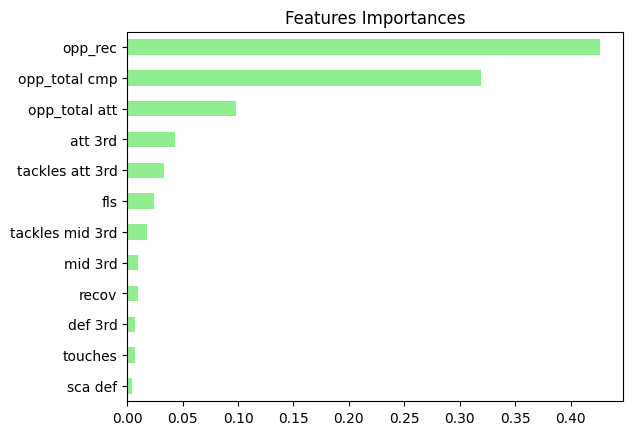

In [104]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_, index= cols)

# Sort importances
importances_sorted = importances.sort_values()[:40]

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [105]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=3,n_estimators=200,random_state=2)

# Fit gb to the training set
gb.fit(X_train, y_train_1d)

# Predict test set labels
y_pred = gb.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 0.089


In [106]:
#Stochastic Gradient Boosting (SGB)

# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate sgbr
sgbr = GradientBoostingRegressor(max_depth=4, 
                                 subsample=0.8,
                                 max_features=0.4,
                                 n_estimators=200,                                
                                 random_state=2)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train_1d)

# Predict test set labels
y_pred = sgbr.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 0.088
